In [1]:
import pdb
from fastai.text import *

In [2]:
print(f'fastai version: {__version__}')

fastai version: 1.0.53.dev


In [3]:
torch.cuda.set_device(1)

In [4]:
PATH = Path('data/translate')
PATH.mkdir(parents=True, exist_ok=True)

DATA_PATH = untar_data(URLs.MT_ENG_FRA)
DATA_PATH.ls()

[PosixPath('/home/wgilliam/.fastai/data/giga-fren/giga-fren.release2.fixed.fr'),
 PosixPath('/home/wgilliam/.fastai/data/giga-fren/giga-fren.release2.fixed.en')]

In [5]:
folder = 'giga-fren.release2.fixed'
en_folder = DATA_PATH/f'{folder}.en'
fr_folder = DATA_PATH/f'{folder}.fr'

## Prepare data

*only need to run through the section 1x to build the .csv file*

In [ ]:
re_eq = re.compile('^(Wh[^?.!]+\?)')
re_fq = re.compile('^([^?.!]+\?)')

lines = ((re_eq.search(eq), re_fq.search(fq)) 
          for eq, fq in zip(open(en_folder, encoding='utf-8'), open(fr_folder, encoding='utf-8')))

qs = [ {'english_text': e.group(), 'french_text': f.group()} for e, f in lines if e and f ]

In [ ]:
qs[:5]

In [ ]:
df = pd.DataFrame(qs)
df.head()

In [ ]:
df.to_csv(PATH/'english_french_translate.csv', index=False)

## Prepare data for training

In [6]:
np.random.seed(42)

In [7]:
df = pd.read_csv(PATH/'english_french_translate.csv')

print(len(df))
display(df.head())

52331


,english_text,french_text
0,What is light ?,Qu’est-ce que la lumière?
1,Who are we?,Où sommes-nous?
2,Where did we come from?,D'où venons-nous?
3,What would we do without it?,Que ferions-nous sans elle ?
4,What is the absolute location (latitude and lo...,Quelle sont les coordonnées (latitude et longi...


**Why am I restricting my datasets to the mean length of French or corresponding English translation?**

Including the longer documents tend to require much more training, consume more memory, and don't necessarily work all that great for models such as we're building here.

In [8]:
MAX_SEQ_LEN = np.max([df.english_text.str.len().mean(), df.french_text.str.len().mean()])

In [9]:
df = df.loc[(df.english_text.str.len() < MAX_SEQ_LEN) & (df.french_text.str.len() < MAX_SEQ_LEN)]
df.reset_index(inplace=True, drop=True)
df.head()

,english_text,french_text
0,What is light ?,Qu’est-ce que la lumière?
1,Who are we?,Où sommes-nous?
2,Where did we come from?,D'où venons-nous?
3,What would we do without it?,Que ferions-nous sans elle ?
4,What is the major aboriginal group on Vancouve...,Quel est le groupe autochtone principal sur l’...


In [10]:
train_df = df.sample(frac=0.8, random_state=42)
valid_df = df.iloc[~df.index.isin(train_df.index)]
len(train_df), len(valid_df)

(25522, 6381)

### Custom DataBlock API code

**Why am I creating my own collate function?**

Two reasons. First, I want to be able to pad both the inputs and targets (the default `pad_collate` function for `TextList` instances only takes are of the inputs).  Second, I wanted to set things up so I could include my targets in training for "teacher forcing" as well as the actual, non-padded, lenghts of each document along with their corresponding masks for masking.

Writing your own `collate_fn` is a nice way to pass in whatever you need/want to your model's `forward()` function.

In [11]:
def seq2seq_pad_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=False, 
                        include_targets=True, include_lengths=True, include_masks=True,
                        backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    
    "Function that collect samples and adds padding. Flips token order if needed"
    
    samples = to_data(samples)
    samples.sort(key=lambda x: len(x[0]), reverse=True)
    
    x_lens = [len(s[0]) for s in samples]
    x_max_len = max(x_lens)
    x_res = torch.zeros(len(samples), x_max_len).long() + pad_idx
    
    y_lens = [len(s[1]) for s in samples]
    y_max_len = max(y_lens)
    y_res = torch.zeros(len(samples), y_max_len).long() + pad_idx
    
    if backwards: pad_first = not pad_first
        
    for i,s in enumerate(samples):
        if pad_first: 
            x_res[i,-len(s[0]):] = LongTensor(s[0])
            y_res[i,-len(s[1]):] = LongTensor(s[1])
        else:         
            x_res[i,:len(s[0]):] = LongTensor(s[0])
            y_res[i,:len(s[1]):] = LongTensor(s[1])
            
    if backwards: res = res.flip(1)
        
    x = [x_res]
    if (include_targets): x += [y_res.clone()]
    if (include_lengths): x += [torch.tensor(x_lens), torch.tensor(y_lens)]
    if (include_masks): x += [x_res != pad_idx, y_res != pad_idx]
    
    return x, y_res

**Why am I creating a custom DataBunch class?**

Because the default class for `TextList` doesn't allow me to override the `collate_fn`.  Everything else pretty much comes right from the framework.

In [12]:
class Seq2SeqDataBunch(DataBunch):

    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, 
               path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1, pad_first=False, dl_tfms=None, 
               device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        
        """Function that transform the `datasets` in a `DataBunch` for classification. 
        Passes `**dl_kwargs` on to `DataLoader()`"""
        
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        
        collate_fn = partial(seq2seq_pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)

Below is one of the reason I like the DataBlock API.  I can inherit all the goodness form `TextList` while just overriding the `DataBunch` class.  Very nice!

In [13]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch

### Build our DataBunch

In [14]:
bs = 64
val_bs = 128

tok_pre_rules = [fix_html, spec_add_spaces, rm_useless_spaces]
tok_post_rules = []

In [15]:
en_tok = Tokenizer(lang='en', pre_rules=tok_pre_rules, post_rules=tok_post_rules)
fr_tok = Tokenizer(lang='fr', pre_rules=tok_pre_rules, post_rules=tok_post_rules)

In [16]:
en_procs = [TokenizeProcessor(tokenizer=en_tok, include_bos=True, include_eos=True), 
            NumericalizeProcessor(min_freq=1)]

fr_procs = [TokenizeProcessor(tokenizer=fr_tok,include_bos=False, include_eos=True), 
            NumericalizeProcessor(min_freq=1)]

In [17]:
en_train_il = Seq2SeqTextList.from_df(train_df, path=PATH, cols=['english_text'], processor=en_procs).process()

en_valid_il = Seq2SeqTextList.from_df(valid_df, path=PATH, cols=['english_text'], 
                                      processor=en_train_il.processor).process()

In [18]:
fr_train_il = Seq2SeqTextList.from_df(train_df, path=PATH, cols=['french_text'], processor=fr_procs).process()

fr_valid_il = Seq2SeqTextList.from_df(valid_df, path=PATH, cols=['french_text'], 
                                      processor=fr_train_il.processor).process()

Remember:  A `LabelList` is a PyTorch `Dataset`

In [19]:
trn_ll = LabelList(fr_train_il, en_train_il)
val_ll = LabelList(fr_valid_il, en_valid_il)

lls = LabelLists(PATH, train=trn_ll, valid=val_ll)

In [20]:
len(lls.train.x.vocab.itos), len(lls.valid.x.vocab.itos), len(lls.train.y.vocab.itos), len(lls.valid.y.vocab.itos)

(15972, 15972, 13416, 13416)

In [21]:
lls.train.x[0]

Text Quelle est la situation actuelle de la DGRH ? xxeos

In [22]:
lls.train.y[0]

Text xxbos What is the current state of affairs in the HRB ? xxeos

In [23]:
print(list(lls.train.x.vocab.itos[:10]))
print(list(lls.train.y.vocab.itos[:10]))

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', '?']
['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', '?']


### Creating a DataBunch via the API

In [24]:
data = lls.databunch(bs=bs, val_bs=val_bs)

In [25]:
b = next(iter(data.train_dl))
b[0][0].shape, b[0][1].shape, b[0][2].shape, b[0][3].shape, b[0][4].shape, b[0][5].shape, b[1].shape

(torch.Size([64, 57]),
 torch.Size([64, 25]),
 torch.Size([64]),
 torch.Size([64]),
 torch.Size([64, 57]),
 torch.Size([64, 25]),
 torch.Size([64, 25]))

### Creating DataBunch via DataLoaders

In [ ]:
train_sampler = SortishSampler(lls.train.x, key=lambda t: len(lls.train[t][0].data), bs=bs//2)
valid_sampler = SortSampler(lls.valid.x, key=lambda t: len(lls.valid[t][0].data))

In [ ]:
train_dl = DataLoader(lls.train, batch_size=bs, sampler=train_sampler, drop_last=True)
valid_dl = DataLoader(lls.valid, batch_size=val_bs, sampler=valid_sampler)

In [ ]:
data = DataBunch(train_dl=train_dl, valid_dl=valid_dl, collate_fn=seq2seq_pad_collate)

In [ ]:
b = next(iter(data.train_dl))
b[0][0].shape, b[0][1].shape, b[0][2].shape, b[0][3].shape, b[0][4].shape, b[0][5].shape, b[1].shape

## Training time

In [26]:
def seq2seq_loss(inputs, targets):
    #pdb.set_trace()
    src_bs, src_seq_len, nc = inputs.shape
    trg_bs, trg_seq_len = targets.shape
    
    if trg_seq_len > src_seq_len: inputs = F.pad(inputs, (0,0,0,trg_seq_len - src_seq_len, 0,0))

    inputs = inputs[:, :trg_seq_len]
    return F.cross_entropy(inputs.contiguous().view(-1, nc), targets.contiguous().view(-1))

In [27]:
class BasicSeq2SeqRnn(nn.Module):
    def __init__(self, src_vocab_sz, src_emb_dim, trg_vocab_sz, trg_emb_dim, n_hidden=256, n_layers=2,
                max_trg_sl=255, trg_PAD_tok_idx=1, trg_BOS_tok_idx=2, trg_EOS_tok_idx=3):
        super().__init__()
        
        self.n_layers, self.n_hidden, self.max_trg_sl = n_layers, n_hidden, max_trg_sl
        
        self.trg_PAD_tok_idx = trg_PAD_tok_idx
        self.trg_BOS_tok_idx = trg_BOS_tok_idx
        self.trg_EOS_tok_idx = trg_EOS_tok_idx
        
        # setup the encoder
        self.enc_emb = nn.Embedding(src_vocab_sz, src_emb_dim)
        self.enc_emb_drop = nn.Dropout(0.15)
        self.enc_rnn = nn.GRU(src_emb_dim, n_hidden, num_layers=n_layers, dropout=0.25, 
                              batch_first=True, bidirectional=True)
        self.enc_out = nn.Linear(n_hidden*2, trg_emb_dim, bias=False)
        
        # setup the decoder
        self.dec_emb = nn.Embedding(trg_vocab_sz, trg_emb_dim)
        self.dec_rnn = nn.GRU(trg_emb_dim, trg_emb_dim, num_layers=n_layers, dropout=0.1, batch_first=True)
        
        self.dec_out_drop = nn.Dropout(0.15)
        self.dec_out = nn.Linear(trg_emb_dim, trg_vocab_sz, bias=False)
        self.dec_out.weight.data = self.dec_emb.weight.data
        
    def forward(self, inputs, targets=None, 
                src_lengths=None, trg_lengths=None, src_mask=None, trg_mask=None):
        
        bs, seq_len = inputs.shape
        h = self.init_hidden(bs).to(device=inputs.device)
        
        enc_emb = self.enc_emb_drop(self.enc_emb(inputs))
        enc_outputs, h = self.enc_rnn(enc_emb, h)
        h = h.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(2,bs,-1)
        h = self.enc_out(h)
        
        trg_max_seq = targets.shape[1] if not targets is None else self.max_trg_sl
        dec_inp = torch.Tensor(bs).fill_(self.trg_BOS_tok_idx).long().to(device=inputs.device)
        
        res = []
        for i in range(trg_max_seq):
            dec_emb = self.dec_emb(dec_inp).unsqueeze(1)
            dec_outputs, h = self.dec_rnn(dec_emb, h)
            dec_out = self.dec_out(self.dec_out_drop(dec_outputs.squeeze()))
            
            res.append(dec_out)
            dec_inp = dec_out.data.max(1)[1]
            
            if ((dec_inp == self.trg_PAD_tok_idx).all()): break
            if (not targets is None): dec_inp = targets[:, i] 
                
        res = torch.stack(res, dim=1)
        return res
    
    def init_hidden(self, bs):
        return torch.zeros(self.n_layers*2, bs, self.n_hidden) # e.g., (2,64,256)
    
    def reset(self):
        pass

In [28]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [29]:
class AttnSeq2SeqRnn(nn.Module):
    def __init__(self, src_vocab_sz, src_emb_dim, trg_vocab_sz, trg_emb_dim, n_hidden=256, n_layers=2,
                max_trg_sl=255, trg_PAD_tok_idx=1, trg_BOS_tok_idx=2, trg_EOS_tok_idx=3):
        super().__init__()
        
        self.n_layers, self.n_hidden, self.max_trg_sl = n_layers, n_hidden, max_trg_sl
        
        self.trg_PAD_tok_idx = trg_PAD_tok_idx
        self.trg_BOS_tok_idx = trg_BOS_tok_idx
        self.trg_EOS_tok_idx = trg_EOS_tok_idx
        
        # setup the encoder
        self.enc_emb = nn.Embedding(src_vocab_sz, src_emb_dim)
        self.enc_emb_drop = nn.Dropout(0.15)
        self.enc_rnn = nn.GRU(src_emb_dim, n_hidden, num_layers=n_layers, dropout=0.25, 
                              batch_first=True, bidirectional=True)
        self.enc_out = nn.Linear(n_hidden*2, trg_emb_dim, bias=False)
        
        # setup the decoder
        self.dec_emb = nn.Embedding(trg_vocab_sz, trg_emb_dim)
        self.dec_rnn = nn.GRU(trg_emb_dim + 2*n_hidden, trg_emb_dim, num_layers=n_layers, dropout=0.1, 
                              batch_first=True)
        
        self.dec_out_drop = nn.Dropout(0.15)
        self.dec_out = nn.Linear(trg_emb_dim, trg_vocab_sz, bias=False)
        self.dec_out.weight.data = self.dec_emb.weight.data
        
        # setup attention
        self.key_layer = nn.Linear(n_hidden*2, n_hidden, bias=False)
        self.query_layer = nn.Linear(trg_emb_dim, n_hidden, bias=False)
        self.energy_layer = nn.Linear(n_hidden, 1, bias=False)
        
    def forward(self, inputs, targets=None, 
                src_lengths=None, trg_lengths=None, src_mask=None, trg_mask=None, return_attns=False):
        
        bs, seq_len = inputs.shape
        h = self.init_hidden(bs).to(device=inputs.device)
        
        enc_emb = self.enc_emb_drop(self.enc_emb(inputs))
        packed = pack_padded_sequence(enc_emb, src_lengths, batch_first=True)
        
        enc_outputs, h = self.enc_rnn(packed, h)
        enc_outputs, _ = pad_packed_sequence(enc_outputs, batch_first=True)
        
        h = h.view(self.n_layers,2,bs,-1).permute(0,2,1,3).contiguous().view(self.n_layers,bs,-1)
        h = self.enc_out(h)
        
        trg_max_seq = targets.shape[1] if not targets is None else self.max_trg_sl
        dec_inp = torch.Tensor(bs).fill_(self.trg_BOS_tok_idx).long().to(device=inputs.device)
        
        attn_key = self.key_layer(enc_outputs) # [64, 12, 512] => [64, 12, 256]
        
        res = []
        attns = []
        for i in range(trg_max_seq):
            dec_emb = self.dec_emb(dec_inp).unsqueeze(1)
            
            # attn
            attn_query = self.query_layer(h[-1].unsqueeze(1)) # [2, 64, 300] => [64, 1, 256]
            attn_scores = self.energy_layer(torch.tanh(attn_query + attn_key)) # => [64, 12, 1]
            attn_scores = attn_scores.squeeze(2).unsqueeze(1) # => [64, 1, 12]
            
            attn_scores.masked_fill_(src_mask.unsqueeze(1) == 0, -float('inf'))
            
            attn_probs = F.softmax(attn_scores, dim=-1)
            attns.append(attn_probs.squeeze())
            
            context = torch.bmm(attn_probs, enc_outputs) # [64, 1, 12] * [64, 12, 512] => [64, 1, 512]
            
            rnn_inp = torch.cat([dec_emb, context], dim=2)
            dec_outputs, h = self.dec_rnn(rnn_inp, h)
            dec_out = self.dec_out(self.dec_out_drop(dec_outputs.squeeze()))
            
            res.append(dec_out)
            dec_inp = dec_out.data.max(1)[1]
            
            if ((dec_inp == self.trg_PAD_tok_idx).all()): break
            if (not targets is None): dec_inp = targets[:, i] 
                
        res = torch.stack(res, dim=1)
        
        if (return_attns): return res, torch.stack(attns, dim=1)
        return res
    
    def init_hidden(self, bs):
        return torch.zeros(self.n_layers*2, bs, self.n_hidden) # e.g., (2,64,256)
    
    def reset(self):
        pass

In [30]:
nh, nl = 512, 2
src_emb_dim, trg_em_dim = 300, 300

src_vocab_sz = len(data.valid_ds.x.vocab.itos)
trg_vocab_sz = len(data.valid_ds.y.vocab.itos)

trg_BOS_idx = data.valid_ds.y.vocab.stoi['xxbos']
trg_EOS_idx = data.valid_ds.y.vocab.stoi['xxeos']
trg_PAD_idx = data.valid_ds.y.vocab.stoi['xxpad']

Another method of implementing "Teacher Forcing" via fastai is through callbacks.  I'm not using it here since I created my own `collate_fn` method above, but here's a link to a forum post discussing it for your consideration: [teacher forcing via callbacks](https://forums.fast.ai/t/teacher-forcing/29415/3).

In [31]:
# one method to include targets for teacher forcing is to include it via a callback ... we assume the model
# has a "self.targets" attribute for such use
class TeacherForcingCallback(LearnerCallback):
    learn:Learner
        
    def on_batch_begin(self, train, **kwargs):
        learn.model.targets = kwargs['last_target']

In [32]:
model = AttnSeq2SeqRnn(src_vocab_sz, src_emb_dim, trg_vocab_sz, trg_em_dim, n_hidden=nh, n_layers=nl,
                        trg_PAD_tok_idx=trg_PAD_idx, trg_BOS_tok_idx=trg_BOS_idx, trg_EOS_tok_idx=trg_EOS_idx)

learn = None, gc.collect()
learn = Learner(data, model)
learn.loss_func = seq2seq_loss

# learn.callbacks.append(TeacherForcingCallback(learn))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


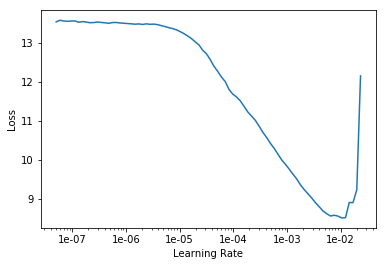

In [33]:
learn.lr_find(start_lr=1e-8, end_lr=1e-1)
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(5, max_lr=3e-3, moms=(0.8,0.99))

epoch,train_loss,valid_loss,time
0,2.813018,2.588876,00:29
1,2.380212,2.293590,00:29
2,2.025493,2.053967,00:29
3,1.650623,1.910961,00:30
4,1.307400,1.915408,00:29


In [35]:
it = iter(data.valid_dl)

In [36]:
x,y = next(it)
learn.model.eval()
probs, attns = learn.model(x[0], x[1], x[2], x[3], x[4], x[5], return_attns=True)
x[0].shape, y.shape, probs.shape

(torch.Size([128, 30]), torch.Size([128, 26]), torch.Size([128, 26, 13416]))

In [37]:
attns.shape

torch.Size([128, 26, 30])

In [38]:
preds = probs.max(2)[1]
preds.shape

torch.Size([128, 26])

In [39]:
en_vocab = learn.data.valid_ds.y.vocab
fr_vocab = learn.data.valid_ds.x.vocab

for i in range(preds.shape[0]):
    print(f'source: {fr_vocab.textify(x[0][i]).replace("xxpad", "")}')
    print(f'actual: {en_vocab.textify(y[i]).replace("xxpad", "")}')
    print(f'pred: {en_vocab.textify(preds[i]).replace("xxpad", "")}\n')

source: Qu' est -ce qui rend la vie agréable à _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ces jours - ci ? xxeos
actual: xxbos What 's good about living in _ _ _ _ _ _ _ _ _ _ these days ? xxeos     
pred: xxbos What is in about this in these _ _ _ _ _ _ _ _ _ _ _ _ xxeos     

source: Quels   sont   les   deux   signaux   à   bras   uniquement   pour   les   xxunk   à   xxunk   ? xxeos  
actual: xxbos Which   2   hand   signals   are   for   xxunk   xxunk   only ? xxeos      
pred: xxbos What                     the the ? ? be ? be xxeos      

source: Quel est le lien entre : [ nom du répondant ] [ ( xxunk , âge ) ] et : [ nom du répondant ] ? xxeos   
actual: xxbos What is the relationship of : [ respondent name ] [ ( Sex , Age ) ] to : [ respondent name ] ? xxeos
pred: xxbos What is the name between the the between between of ? ] ] ] and ) of ? the the ? ] ? ? xxeos

source: Si le travailleur est debout , l’ objet à soulever xxunk - t - il moins de 23 kg ( 51 xxunk ) ? xxeos     
actual: xxbos 

source: Que se produit - il si la technologie n' est pas disponible ou n' est pas adoptée ? xxeos           
actual: xxbos What happens if the technology is not available or implemented ? xxeos             
pred: xxbos What if if the is is not available or the ? xxeos             

source: Pourquoi envoyer de l’ argent à Bruxelles , pour qu’ il nous soit xxunk par la suite ? xxeos           
actual: xxbos Why send the money to xxunk , and then get it back again ? xxeos          
pred: xxbos Why are the future , we we what what ? the ? ? ? xxeos          

source: Pourquoi l' information météorologique n' a - t - elle pas été mise à jour xxunk xxunk ? xxeos           
actual: xxbos Why has n't the weather information been updated xxunk xxunk ? xxeos             
pred: xxbos Why was n’t been information been been made ? ? ? xxeos             

source: Et xxunk tout , pourquoi ´ ` ` ´ ´ ˆ mettre la province a l’ xxunk ? xxeos           
actual: xxbos Why are they xxunk the province anyway

In [40]:
def plot_attns(src, trg, scores):
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(scores, cmap='viridis')
    
    ax.set_xticklabels(trg, minor=False, rotation='vertical')
    ax.set_yticklabels(src, minor=False)
    
    # put the major ticks at the middel of each cell and the x-ticks on top
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()
    
    plt.colorbar(heatmap)
    plt.show()

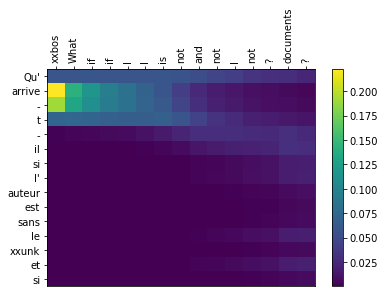

In [41]:
idx = 5
src = [ fr_vocab.itos[i] for i in x[0][idx] ]
trg = [ en_vocab.itos[i] for i in preds[idx] ]

plot_attns(src[:15], trg[:15], attns[idx,:15,:15])